In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import datetime
import pickle
from utilsTorch import *
from dataset import *
from model import *


print(idx2label)
print(label2idx)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}
{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
cuda:0


In [2]:
voc_train_2007 = torchvision.datasets.VOCDetection(root="voc",year="2007",image_set="trainval",download=False)
voc_train_2012  = torchvision.datasets.VOCDetection(root="voc",year="2012",image_set="train",download=False)
voc_val = torchvision.datasets.VOCDetection(root="voc",year="2012",image_set="val",download=False)
voc_test = torchvision.datasets.VOCDetection(root="voc",year="2007",image_set="test",download=False)

voc_train_images = voc_train_2007.images+voc_train_2012.images

In [3]:
t1=datetime.datetime.now()
voc_train_2007_annotations = createLabels(voc_train_2007)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_train_2007_annotations.shape)

Elapsed time is : 69.187512 seconds 
(5011, 7, 7, 30)


In [4]:
t1=datetime.datetime.now()
voc_train_2012_annotations = createLabels(voc_train_2012)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_train_2012_annotations.shape)

Elapsed time is : 62.899416 seconds 
(5717, 7, 7, 30)


In [5]:
voc_train_annotations = np.append(voc_train_2007_annotations,voc_train_2012_annotations,axis=0)

In [6]:
t1=datetime.datetime.now()
voc_val_annotations = createLabels(voc_val)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_val_annotations.shape)

Elapsed time is : 64.024395 seconds 
(5823, 7, 7, 30)


In [7]:
t1=datetime.datetime.now()
voc_test_annotations = createLabels(voc_test)
t2=datetime.datetime.now()
diff = t2-t1   
print(f"Elapsed time is : {diff.total_seconds()} seconds ")

print(voc_test_annotations.shape)

Elapsed time is : 62.664005 seconds 
(4952, 7, 7, 30)


0 voc\VOCdevkit\VOC2007\JPEGImages\000001.jpg torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


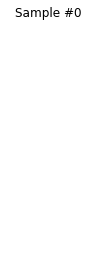

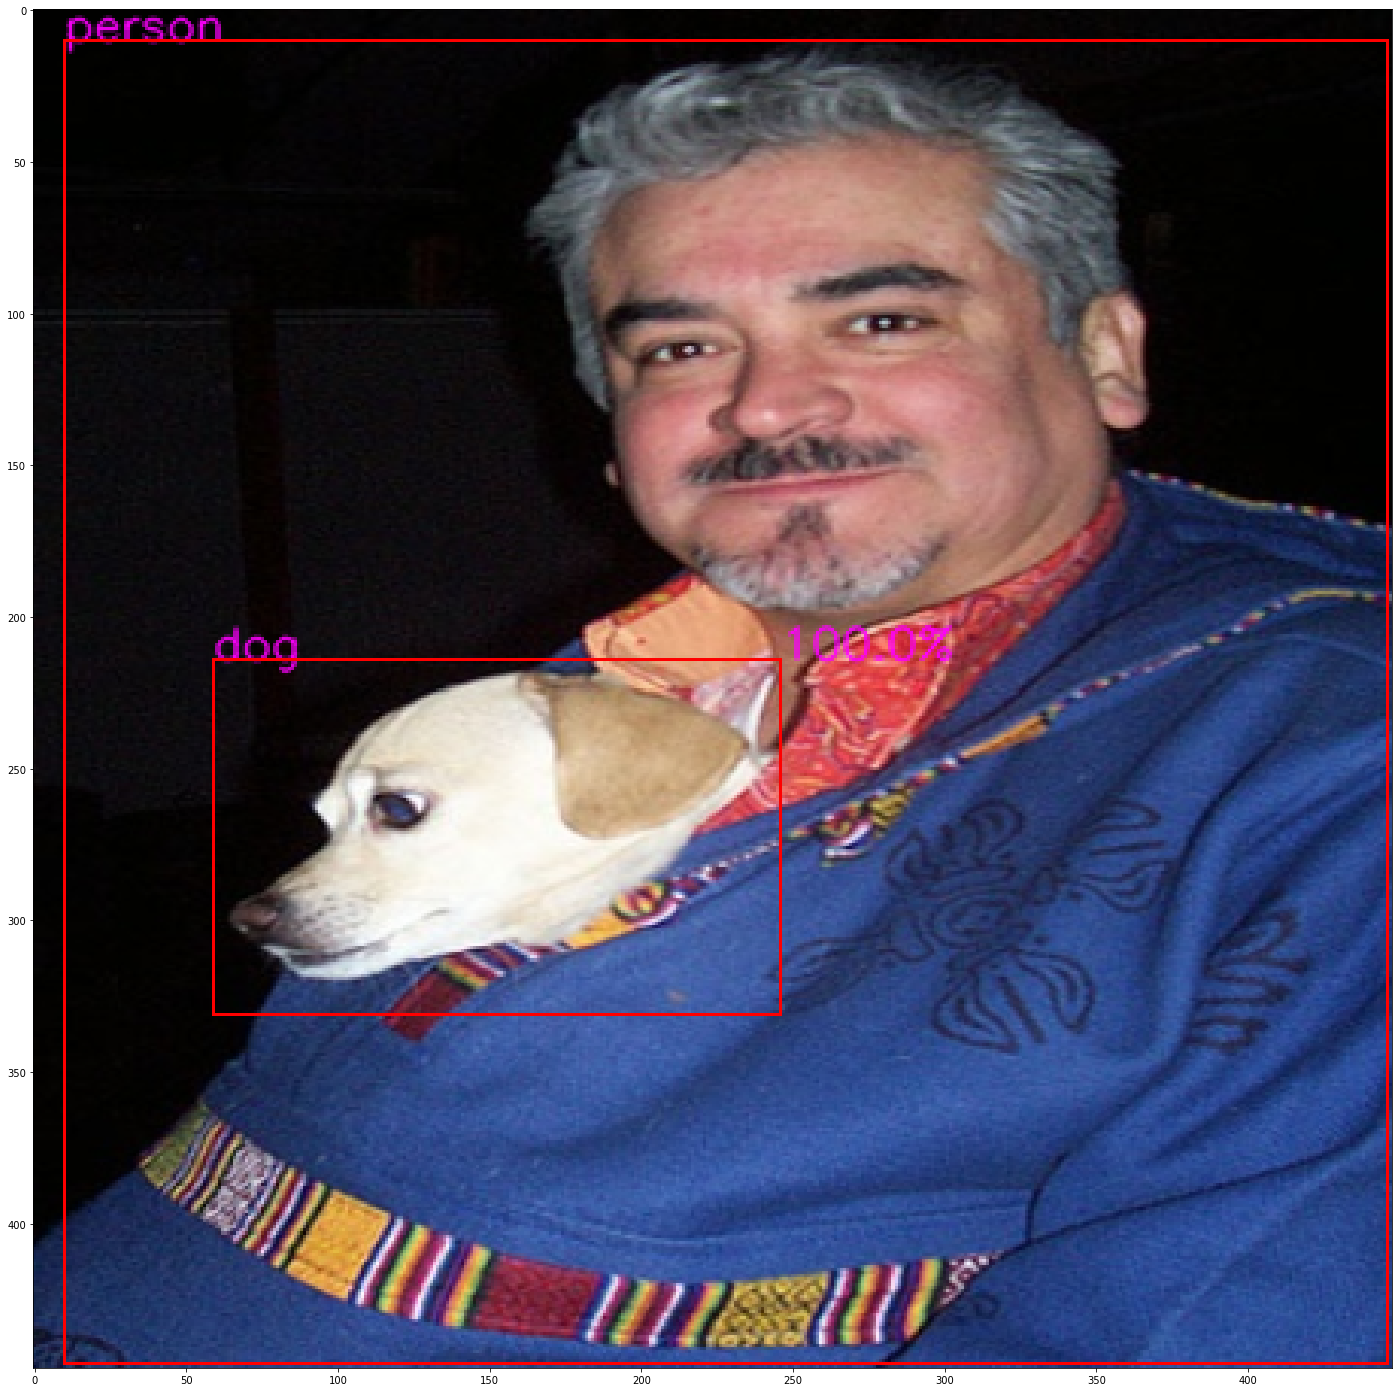

1 voc\VOCdevkit\VOC2007\JPEGImages\000002.jpg torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


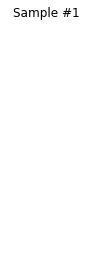

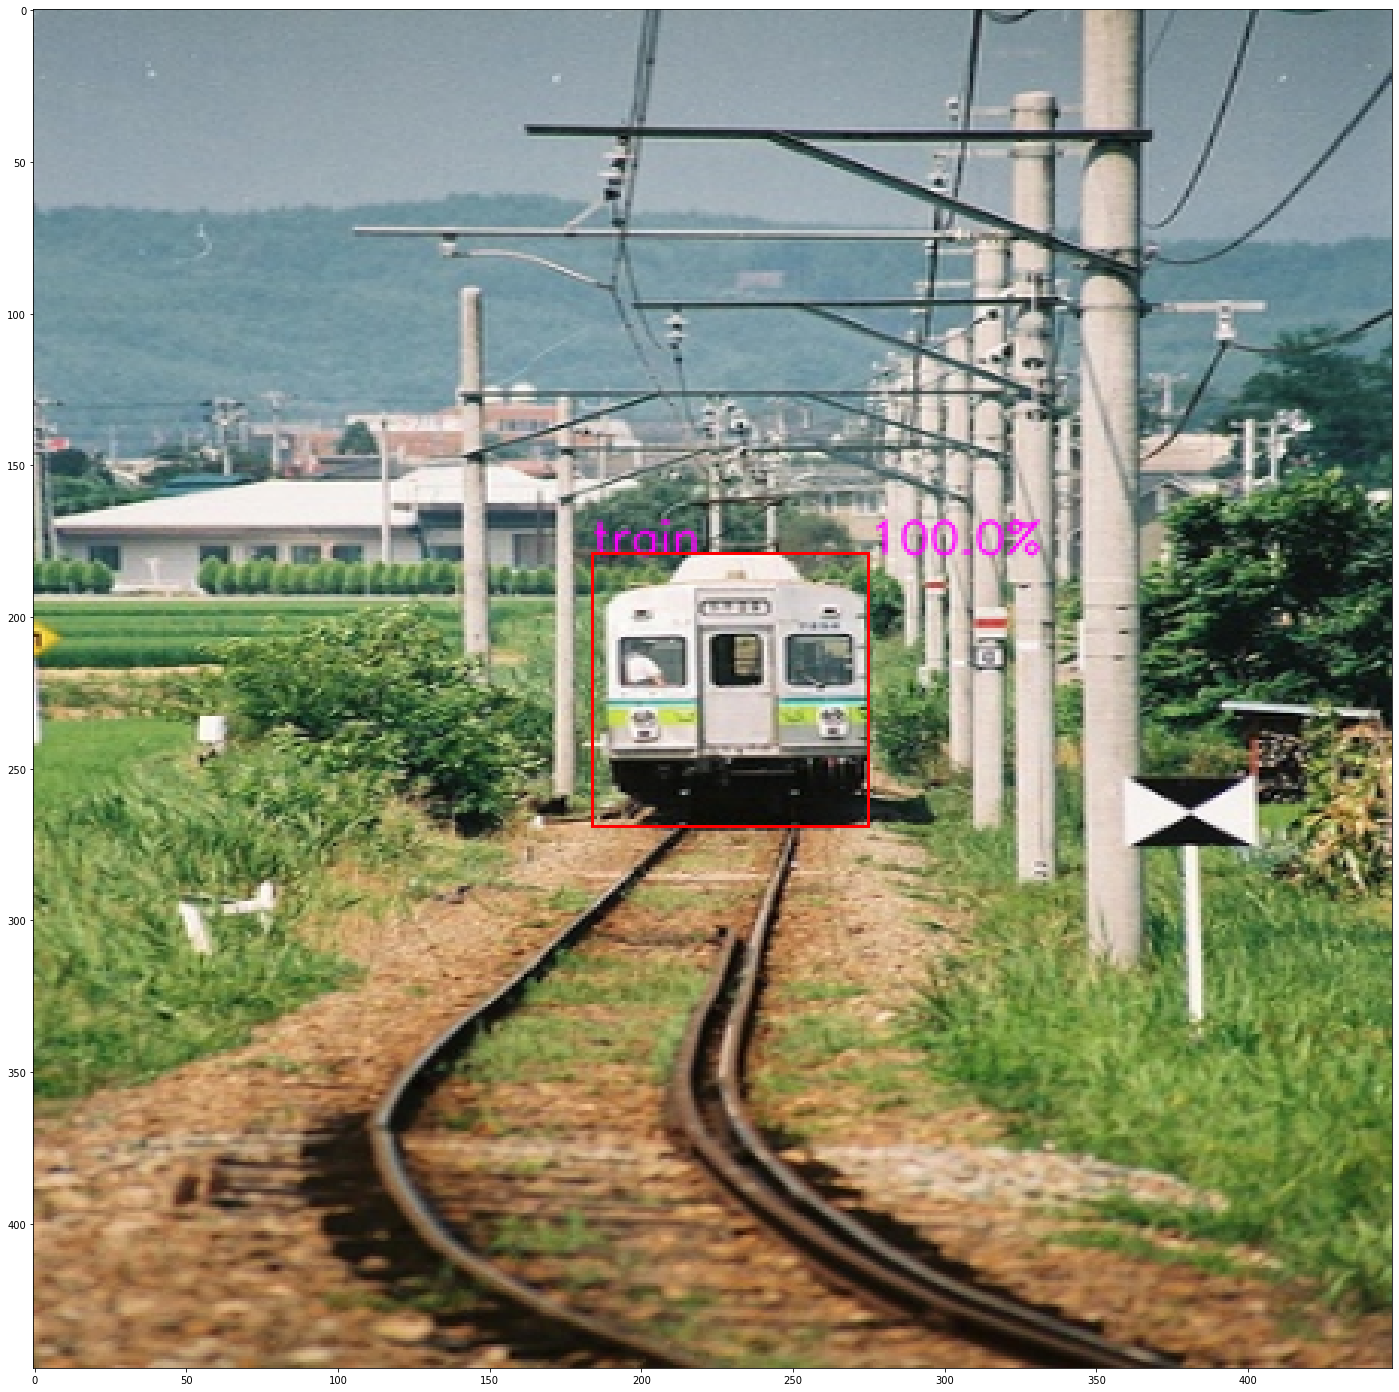

2 voc\VOCdevkit\VOC2007\JPEGImages\000003.jpg torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


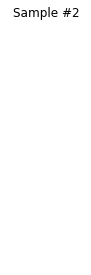

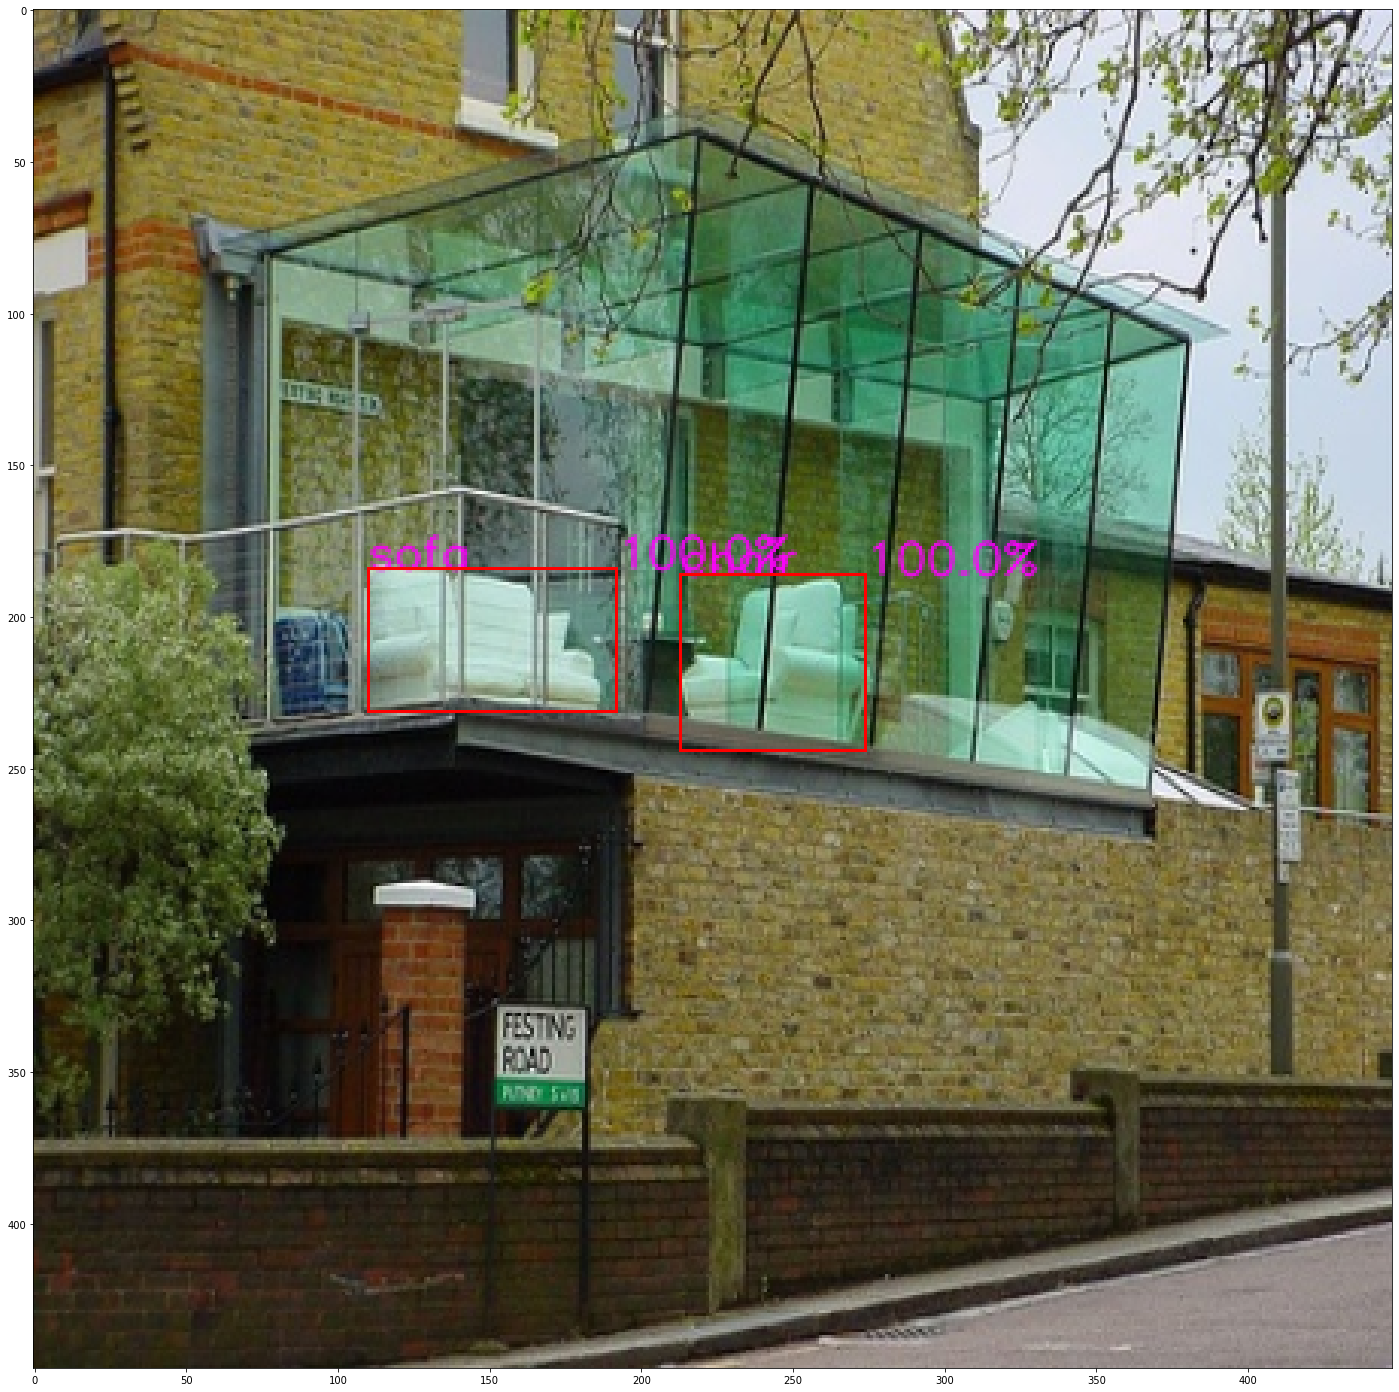

3 voc\VOCdevkit\VOC2007\JPEGImages\000004.jpg torch.Size([3, 448, 448]) torch.Size([7, 7, 30])


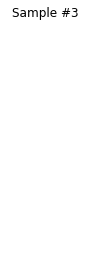

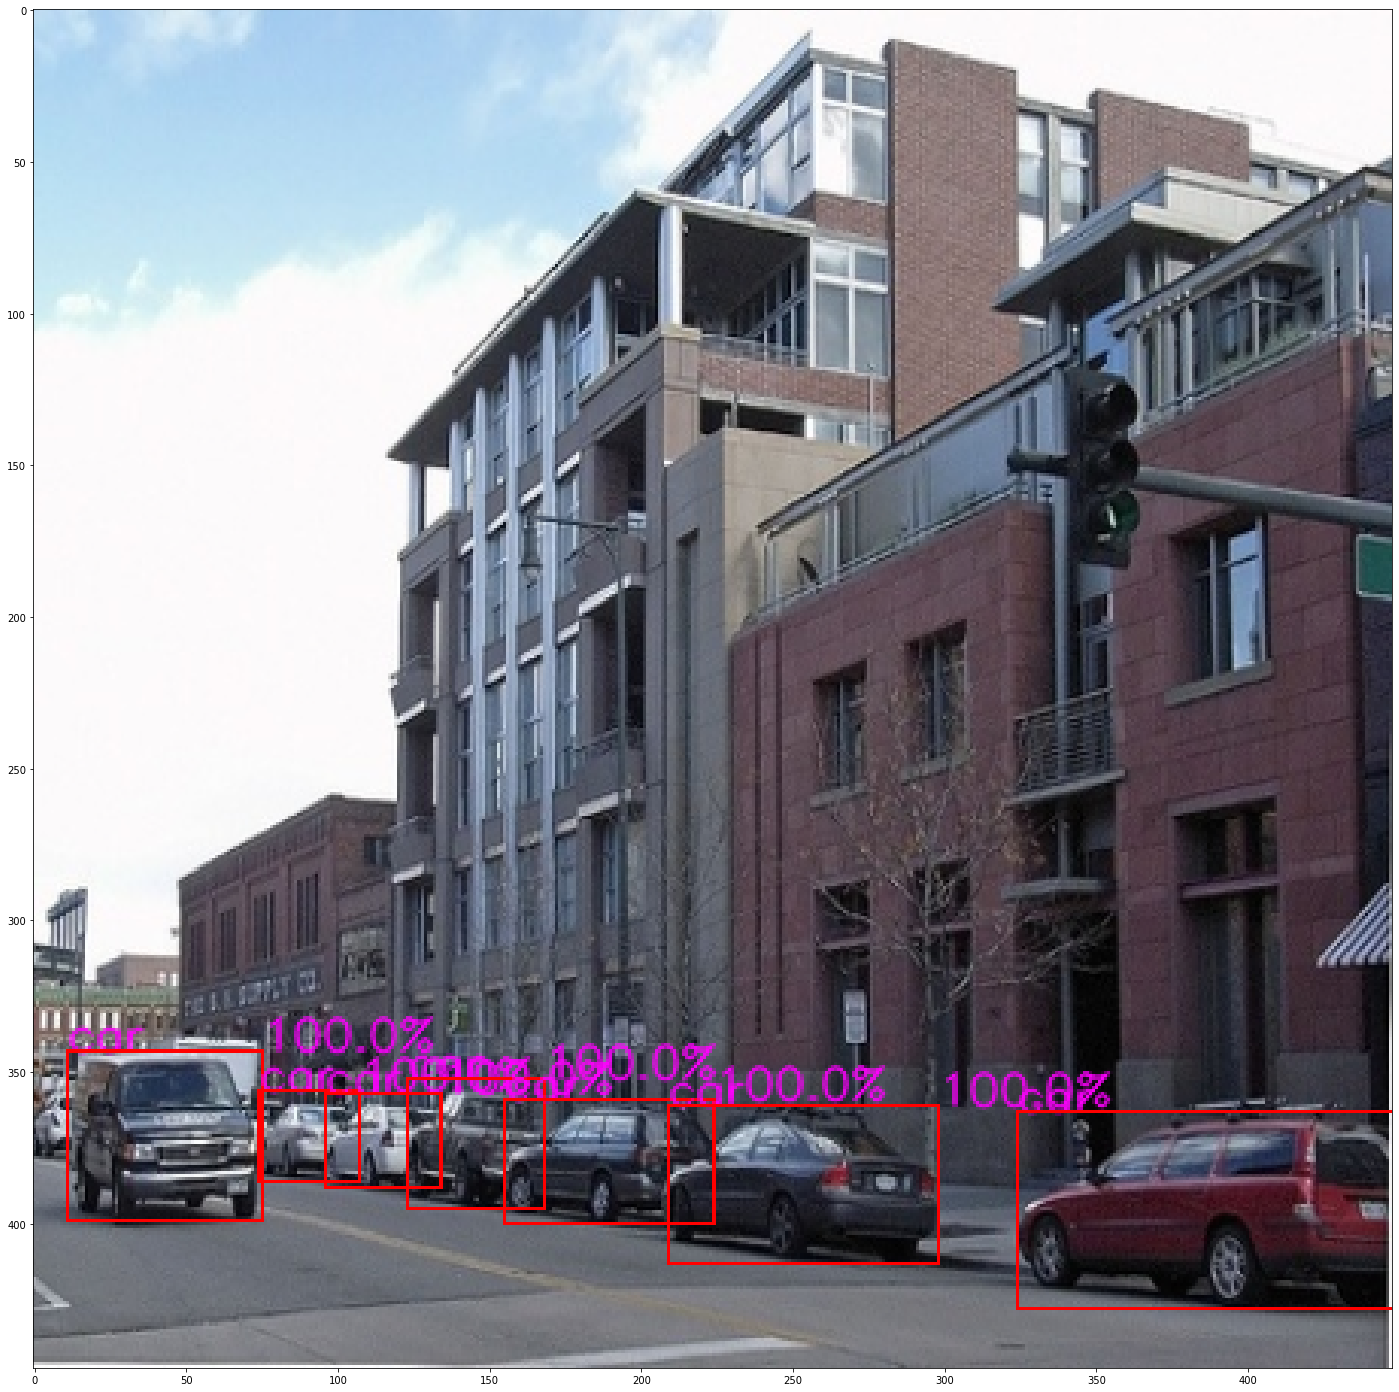

In [8]:
train = VOCDataset(voc_train_annotations,voc_train_images,transform=transforms.Compose([
                                               Rescale(new_size),ToTensor()
                                           ]))
val = VOCDataset(voc_val_annotations,voc_val.images,transform=transforms.Compose([
                                               Rescale(new_size),ToTensor()
                                           ]))

test = VOCDataset(voc_test_annotations,voc_test.images,transform=transforms.Compose([
                                               Rescale(new_size),
                                            ToTensor()
                                           ]))
data = test
fig = plt.figure()

for i in range(len(data)):
    sample = data[i]

    print(i,sample['name'], sample['image'].shape, sample['annotation'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    showSample(sample)

    if i == 3:
        plt.show()
        break

0 16 torch.Size([16, 3, 448, 448]) torch.Size([16, 7, 7, 30])
1 16 torch.Size([16, 3, 448, 448]) torch.Size([16, 7, 7, 30])
2 16 torch.Size([16, 3, 448, 448]) torch.Size([16, 7, 7, 30])
3 16 torch.Size([16, 3, 448, 448]) torch.Size([16, 7, 7, 30])


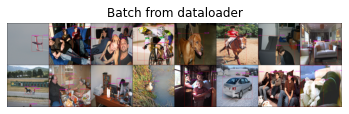

In [9]:
batch_size = 16
epochs = 5
trainLoaders = {}


trainLoader = DataLoader(train, batch_size,
                        shuffle=True, num_workers=2)

valLoader = DataLoader(val, 16,
                        shuffle=True, num_workers=2)

testLoader = DataLoader(test, batch_size=16,
                        shuffle=False, num_workers=2)


trainLoaders["train"] = trainLoader
trainLoaders["val"] = valLoader

for i_batch, sample_batched in enumerate(trainLoader):
    print(i_batch, len(sample_batched['name']),
          sample_batched['image'].size(),
            sample_batched['annotation'].size())

    if i_batch == 3:
        plt.figure()
        show_annotations_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [10]:
torch.cuda.empty_cache()
modelName = "mobilenet"
fileName = f"yolo-back-{modelName}-weights"
model = YOLOv1(modelName).to(device)

In [11]:
optimizer = optim.Adam(model.parameters(),lr = 0.0001)

In [12]:
params_to_update = model.parameters()
print("Params to learn:")
s = 0
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        s+=param.data.reshape(-1).shape[0]
        print("\t",name)

print(s)


Params to learn:
	 conv.0.weight
	 conv.0.bias
	 conv.1.weight
	 conv.1.bias
	 conv.2.weight
	 conv.2.bias
	 conv.3.weight
	 conv.3.bias
	 conv.4.weight
	 conv.4.bias
	 conv.5.weight
	 conv.5.bias
	 fc1.weight
	 fc1.bias
	 predictor.weight
	 predictor.bias
50337214


In [ ]:
#model.load_state_dict(torch.load(f"trained/{fileName}"))
model = train_model(model,trainLoaders,yoloLoss,optimizer,5,device = device,isSave=True,filename=fileName,verbose = False,isSupress=True)

Epoch 0/4
----------


Predicting ...:   0%|          | 0/671 [00:04<?, ?it/s]

Predicting ...:   0%|          | 0/310 [00:03<?, ?it/s]

Non Max Supressing ...:   0%|          | 0/4952 [00:00<?, ?it/s]

calculating true positive rate:   0%|          | 0/4952 [00:00<?, ?it/s]

Computing ap:   0%|          | 0/98890 [00:00<?, ?it/s]

 Average Precision : 46.49%

Evaluating complete in 2m 46s


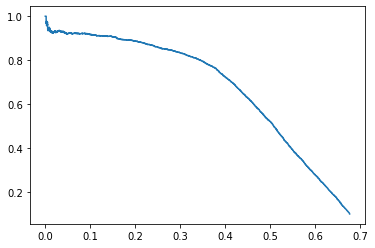

In [17]:
ap = evaluate_model(model,testLoader,device,iou_thresh = 0.1,isSupress = True,supressThresh = 0.7)

In [14]:
model.load_state_dict(torch.load(f"trained/{fileName}"))

<All keys matched successfully>

Non Max Supressing ...:   0%|          | 0/2 [00:00<?, ?it/s]

tensor(7.2284, device='cuda:0')


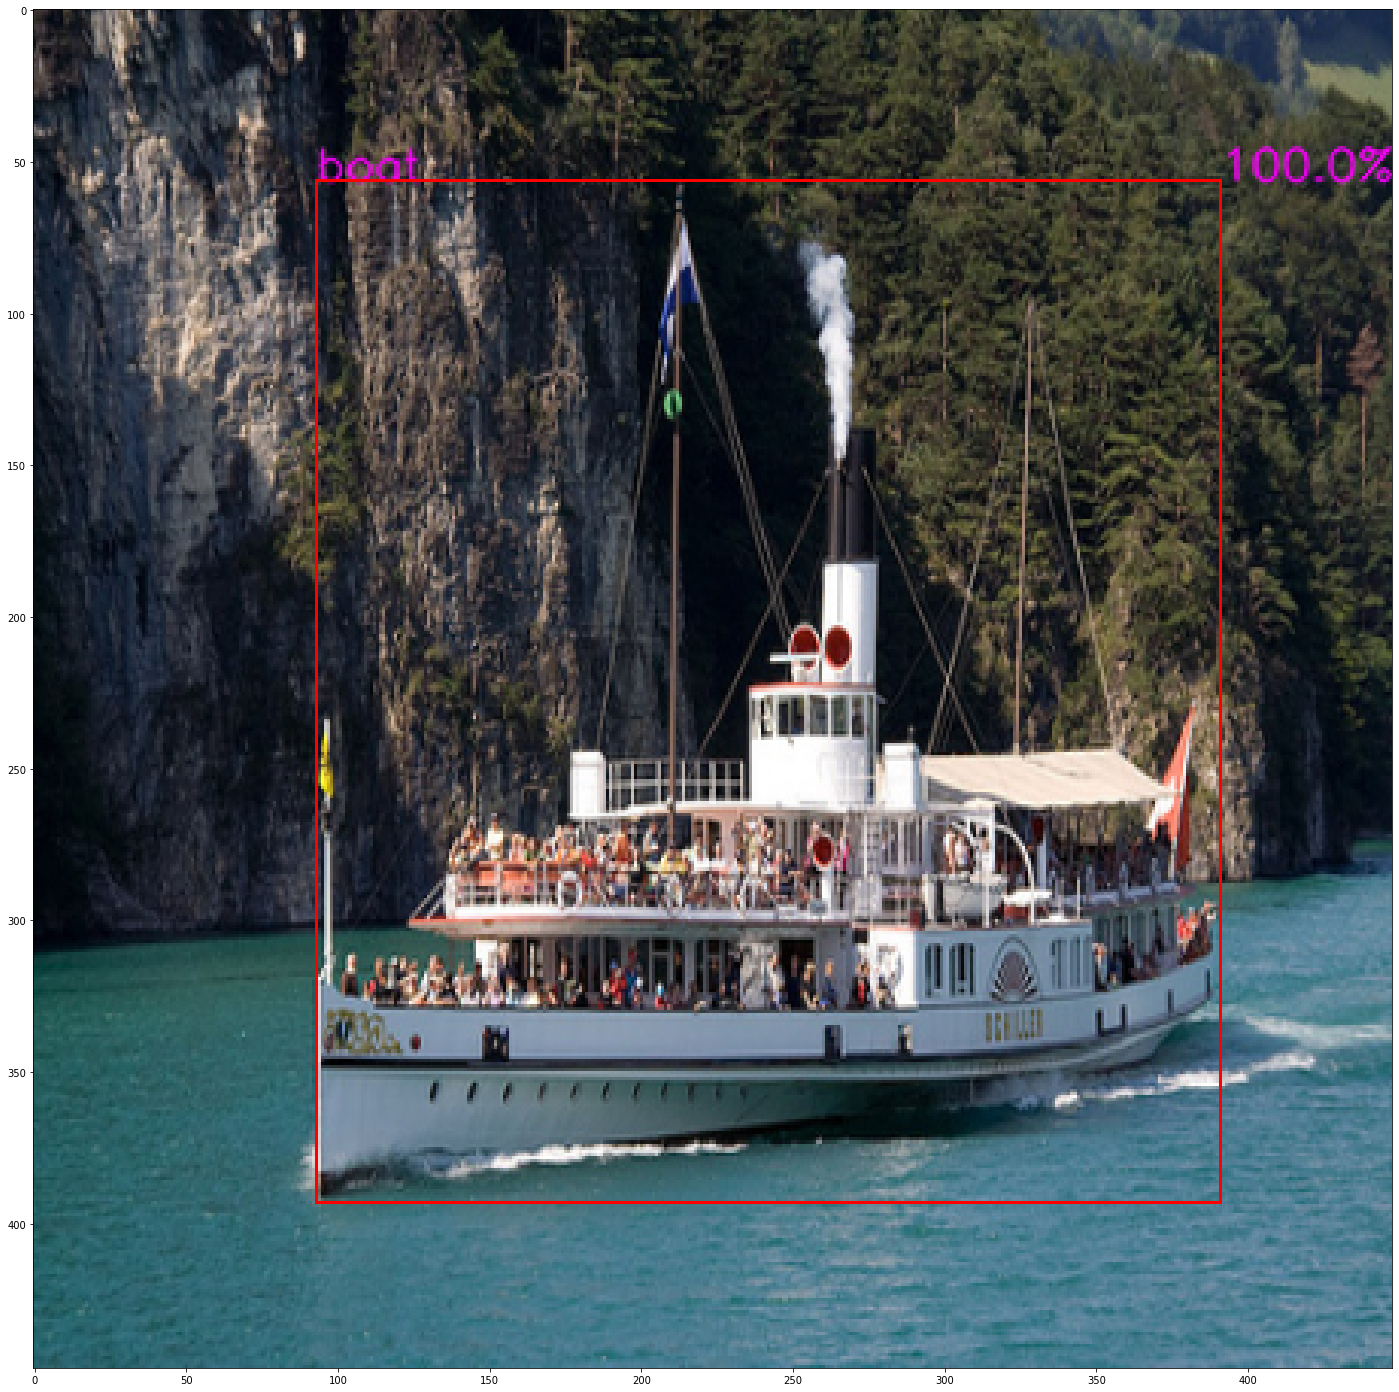

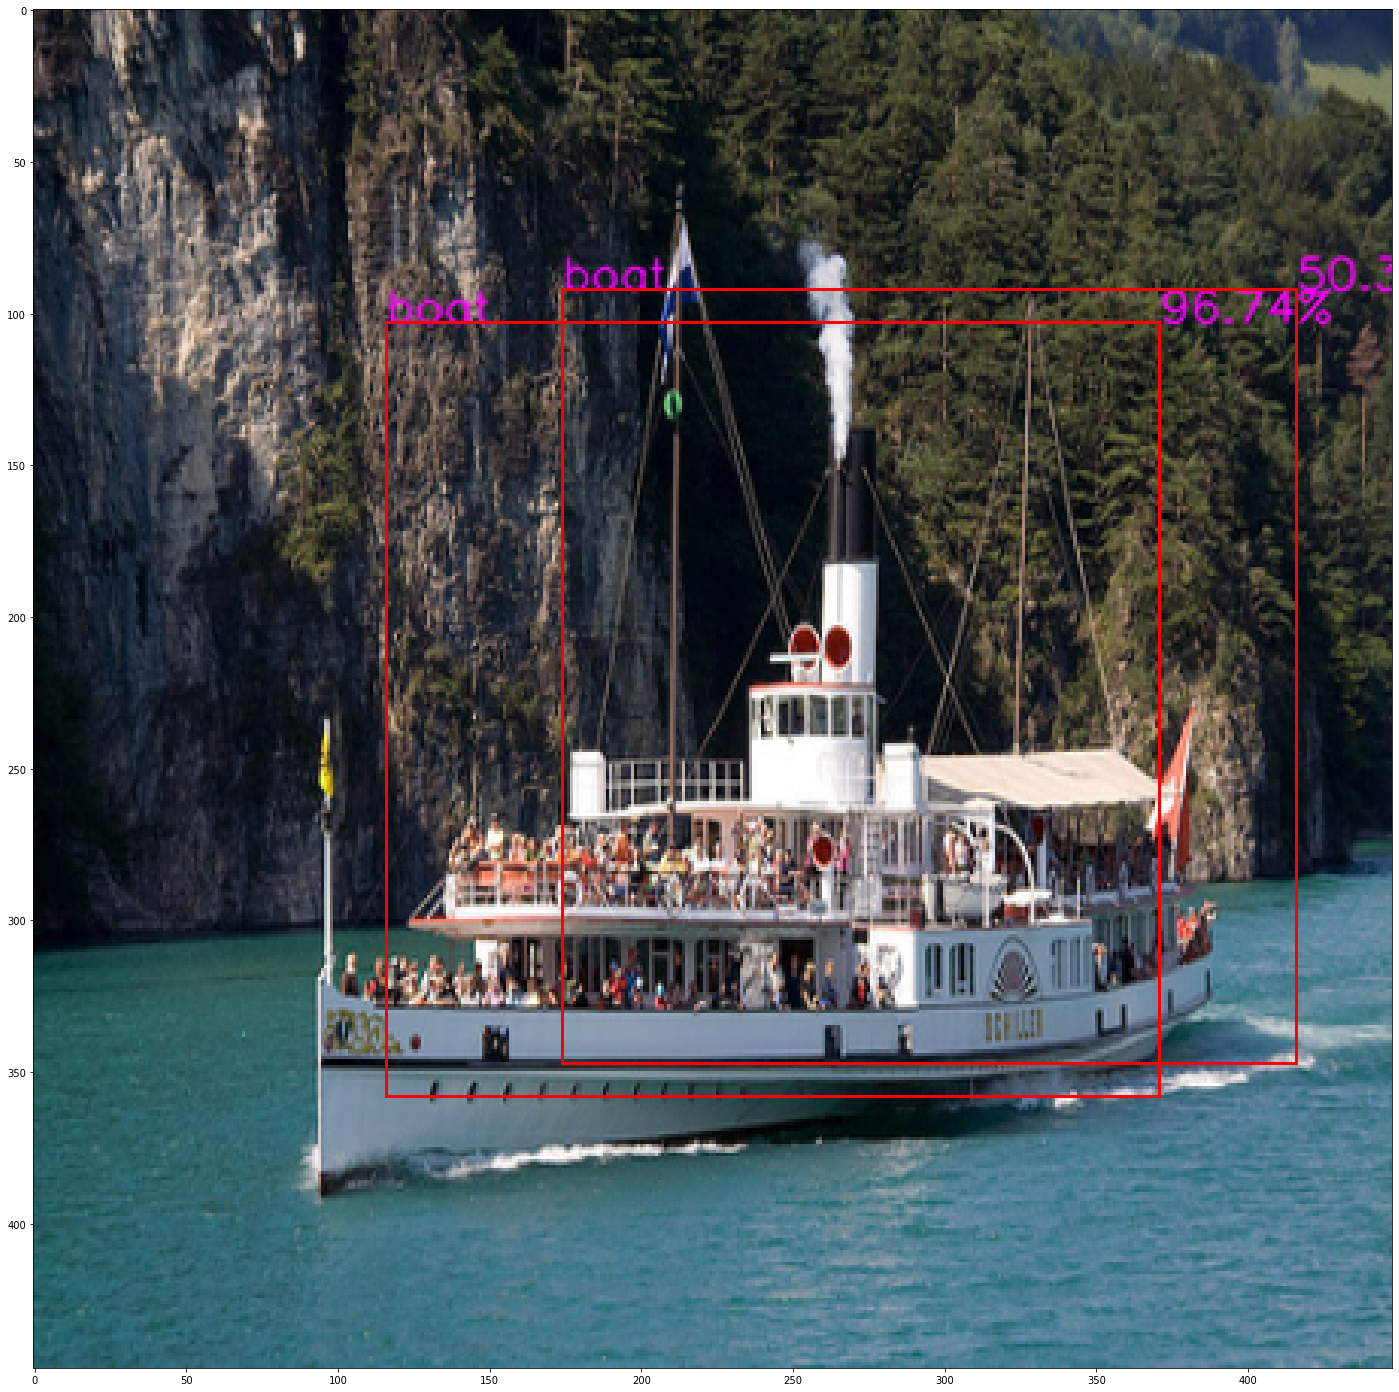

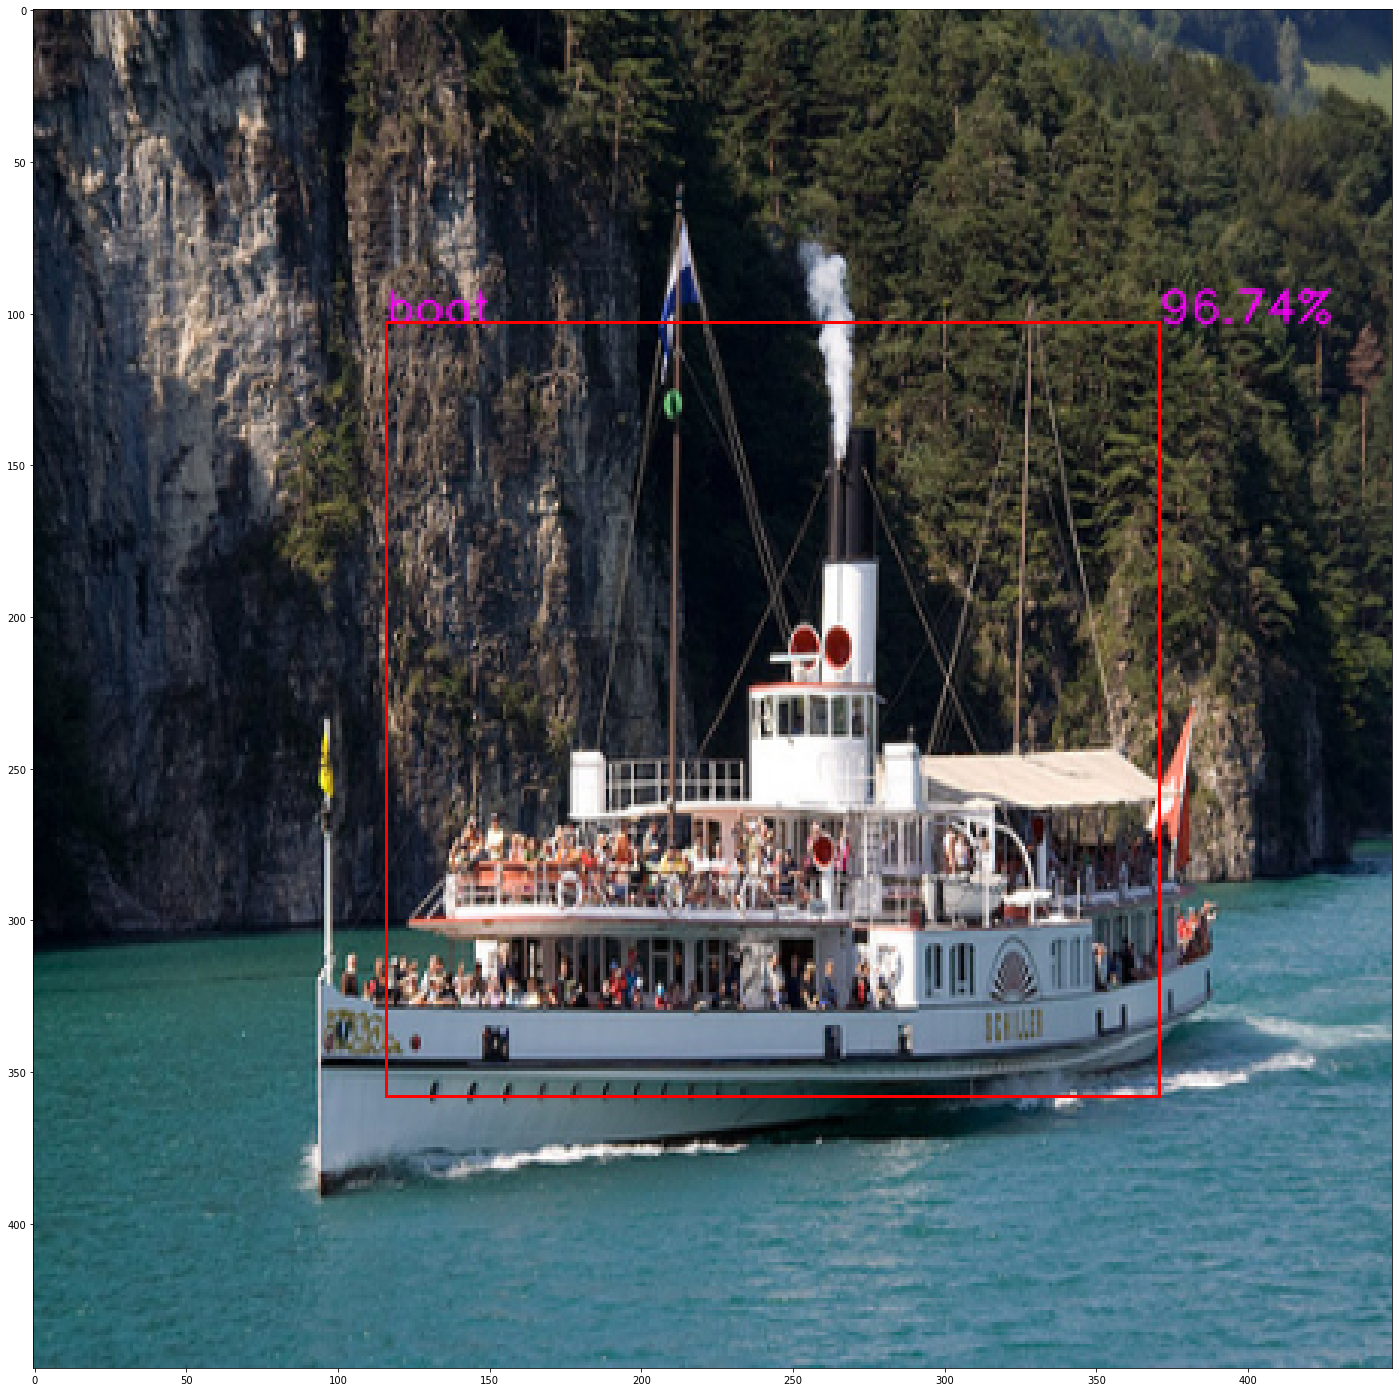

In [18]:
names = []
inputs = torch.zeros((2,3,448,448)).to(device)
labels = torch.zeros((2,7,7,30)).to(device)
data = train

for i in range(2):
    
    idx = torch.randint(low = 0,high = len(data),size = (1,)).item()

    names.append(data[idx]['name'])

    inputs[i] = data[idx]["image"]

    labels[i] = data[idx]["annotation"]


model.eval()
preds = model(inputs/255).view(labels.shape).detach()

true_dict = toDict(names,labels.cpu(),True)
preds_dict = toDict(names,preds.cpu(),False)
supredd_preds = nonMaxSupress(preds_dict,0.8)
new_preds = toGrid(preds,supredd_preds,device)

print(yoloLoss(labels.float(),new_preds.float(),5,0.5))

sample ={"image":data[idx]["image"],"annotation":labels[1].cpu()}
out = showSample(sample,0.7)
sample ={"image":data[idx]["image"],"annotation":preds[1].cpu()}
out = showSample(sample,0.5)
sample ={"image":data[idx]["image"],"annotation":new_preds[1].cpu()}
out = showSample(sample,0.5)

## NOT SAME CLASS SUPRESS